In [3]:
from PIL import Image
import pandas as pd
import os
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.feature import canny
from skimage.measure import regionprops, label
!pip install opencv-python
import cv2
from scipy.optimize import curve_fit

In [26]:


def load_ascii(file_path):
    # Read the comma-delimited ASCII file into a DataFrame
    df = pd.read_csv(file_path, delimiter='\t', header=None)
    return df

def delete(df):
    # Delete the first and last columns
    df = df.iloc[:, 1:-1]
    return df

def intensity(directory, bg_new):
    intensities = {}
    
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.asc'):
            # Extract delay time from the filename
            delay_time = float(filename.split('_')[0].replace('ns', ''))
            file_path = os.path.join(directory, filename)
            
            # Load the ASCII file into a DataFrame
            df = load_ascii(file_path)
            df = delete(df)
            df -= bg_new
            df = df.T
            total_intensity = df.values.sum()
            
            if delay_time not in intensities:
                intensities[delay_time] = []
            intensities[delay_time].append(total_intensity)
    
    return intensities

def calculate(intensities):
    avg_intensities = {}
    uncertainties = {}
    
    for delay_time, values in intensities.items():
        avg_intensities[delay_time] = np.mean(values)
        uncertainties[delay_time] = np.std(values)   # Standard error of the mean
    
    return avg_intensities, uncertainties

def plot(avg_intensities, uncertainties, media, height):
    delay_times = sorted(avg_intensities.keys())
    avg_values = [avg_intensities[dt] for dt in delay_times]
    uncertainty_values = [uncertainties[dt] for dt in delay_times]
    
    plt.errorbar(delay_times, avg_values, yerr=uncertainty_values, fmt='o', capsize=5, capthick=2, ecolor='red')
    plt.xlabel('Delay Time (ns)')
    plt.ylabel('Total Intensity')
    plt.title(f'Total Intensity vs Delay Time for {media} at {height}mm')
    plt.show()

def spatial(directory, bg_new, height, output_dir):
    data_dict = {}

    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.asc'):
            # Extract delay time and trial number from the filename
            delay_time = int(filename.split('_')[0].replace('ns', ''))
            trial = int(filename.split('_')[1].split('.')[0])
            file_path = os.path.join(directory, filename)
            
            # Load the ASCII file into a DataFrame
            df = load_ascii(file_path)
            df = delete(df)
            df -= bg_new
            df = df.T
            
            # Sum along the x direction
            spatial_profile = np.sum(df, axis=0)
            
            # Store the spatial profile in the dictionary
            if delay_time not in data_dict:
                data_dict[delay_time] = []
            data_dict[delay_time].append(spatial_profile)
    
    # Process each delay time to calculate the average and standard deviation
    for delay_time, profiles in data_dict.items():
        profiles = np.array(profiles)
        avg_profile = np.mean(profiles, axis=0)
        std_profile = np.std(profiles, axis=0)
        
        # Plot the average spatial profile with standard deviation
        plt.figure()
        plt.errorbar(range(len(avg_profile)), avg_profile, fmt='-o', capsize=5)
        plt.xlabel('X position')
        plt.ylabel('Intensity')
        plt.xscale('log')
        plt.yscale('log')
        plt.title(f'Spatial Profile along X at {height}mm and {delay_time}ns')
        
        # Save the plot
        output_path = os.path.join(output_dir, f'Spatial_along_x_at_{height}mm/{delay_time}ns.png')
        plt.savefig(output_path)
        plt.close()

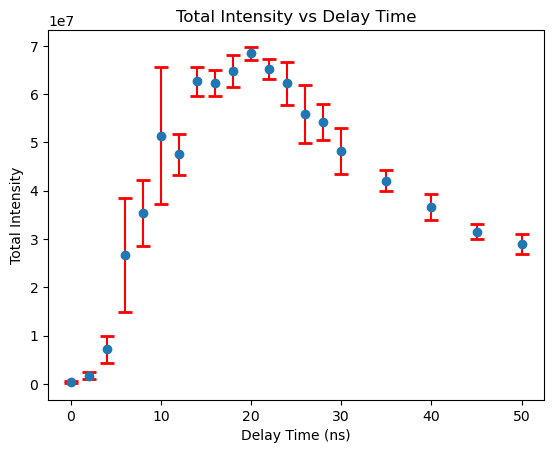

In [58]:
df2 = load_ascii('/Users/YK/Desktop/24_06_07_Air_Cam2/ASCII/40ns_1.asc')

In [59]:
df2 = df2.drop(columns = df2.columns[0]).drop(columns = df2.columns[1025])

In [60]:
df2

,1,2,3,4,5,6,7,8,9,10,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,669,684,632,659,675,671,675,645,645,667,...,648,662,672,681,676,657,659,648,639,651
1,673,657,663,672,670,678,697,699,670,679,...,689,685,673,675,659,650,674,664,693,658
2,703,681,669,656,671,670,676,665,648,690,...,642,699,660,642,650,653,644,665,631,668
3,676,668,662,659,691,693,671,675,638,655,...,669,662,678,656,665,665,673,672,667,654
4,691,670,678,653,681,687,664,682,652,659,...,647,661,647,690,678,651,696,659,653,676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,652,664,647,661,657,655,665,660,653,679,...,664,673,676,688,656,608,647,651,695,672
1020,706,719,664,646,665,675,694,651,691,643,...,664,670,660,671,680,651,656,655,675,660
1021,630,666,670,660,665,657,675,686,652,665,...,674,649,641,638,637,690,696,635,657,649
1022,641,661,652,685,664,673,691,648,670,676,...,659,670,656,617,654,656,668,645,665,649


In [61]:
df2 -= bg_air

In [62]:
df2 = df2.T

In [63]:
df2

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
1,-17,-3,27,-9,22,-39,32,14,-12,-13,...,6,14,-21,8,-13,-31,50,-68,-7,8
2,-12,-16,12,-19,20,23,-2,-33,0,-21,...,22,24,5,28,13,-1,36,-11,-20,25
3,-4,0,49,-16,-17,23,31,-4,25,11,...,-15,-4,5,9,-10,-47,-6,-11,-5,-13
4,-16,-27,-8,-18,9,-36,-9,-5,3,6,...,-27,33,5,-24,-14,-6,-46,-1,43,41
5,-33,26,-7,14,28,-22,8,26,-21,-10,...,15,-10,-14,23,6,-8,8,-14,24,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,12,-18,-12,19,-17,46,-5,51,5,35,...,-10,38,21,-31,-31,-62,-19,38,-12,6
1021,17,12,-32,-4,31,-2,19,45,-4,-16,...,-43,-18,-16,-24,1,-3,4,36,27,-27
1022,16,2,-12,23,13,-18,9,19,-48,22,...,25,15,-50,-31,4,-25,3,-37,-23,2
1023,-21,14,-28,32,-29,10,-42,7,5,-12,...,30,-27,19,0,31,47,2,12,-2,-26


Processing helium at 2mm...


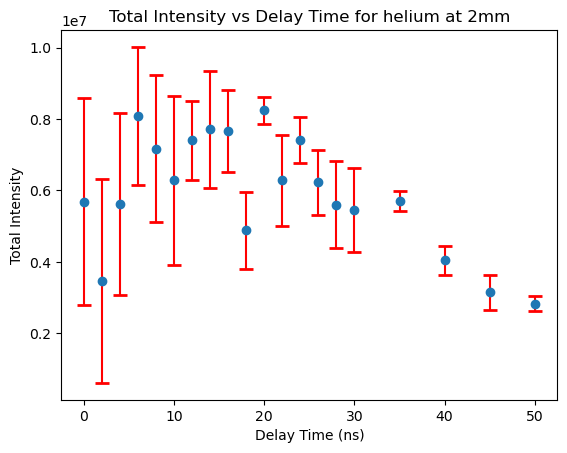

Processing helium at 3mm...


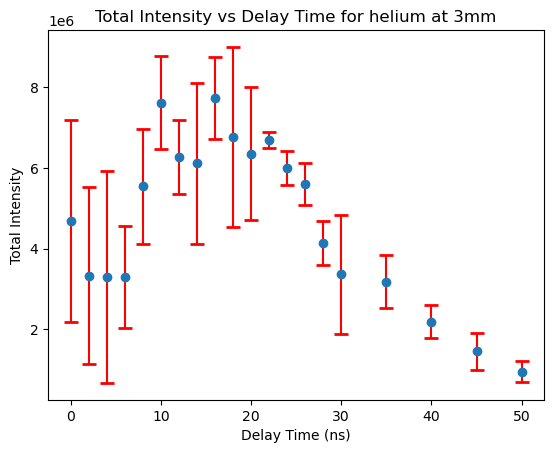

Processing helium at 4mm...


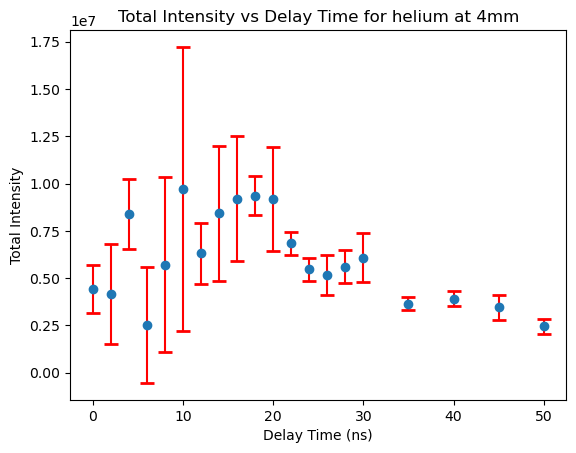

Processing helium at 5mm...


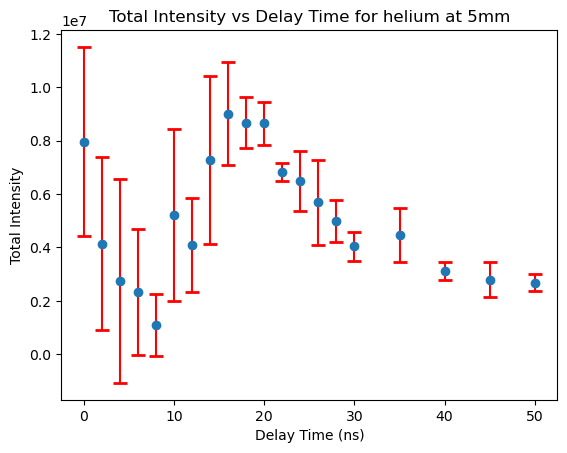

Processing helium at 6mm...


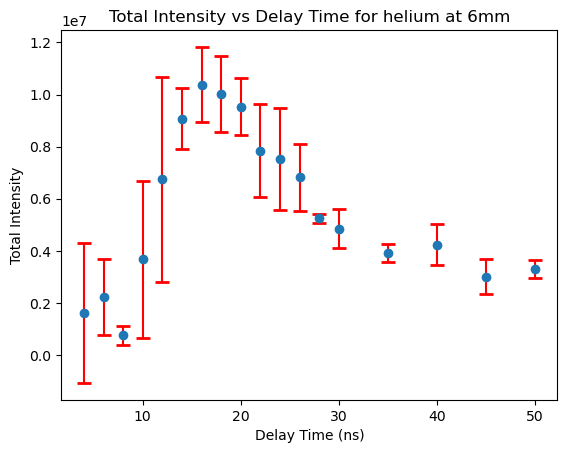

In [39]:
def process_media_conditions(base_directory, media):
    heights = range(2, 7, 1)
    
    for height in heights:
        bg_directory = os.path.join(base_directory, f'{height}mm', 'bg')
        data_directory = os.path.join(base_directory, f'{height}mm', 'ASCII')
        
        if os.path.exists(bg_directory) and os.path.exists(data_directory):
            print(f'Processing {media} at {height}mm...')
            
            # Load the background file
            bg_file_path = os.path.join(bg_directory, 'background.asc')
            if os.path.exists(bg_file_path):
                bg_new = load_ascii(bg_file_path)
                bg_new = delete(bg_new)
                
                # Process the data files
                intensities = intensity(data_directory, bg_new)
                avg_intensities, uncertainties = calculate(intensities)
                plot(avg_intensities, uncertainties, media, height)
            else:
                print(f'Background file {bg_file_path} does not exist, skipping.')
        else:
            print(f'Directory {data_directory} or {bg_directory} does not exist, skipping.')

# Define base directories for each media

# Process each media and its conditions
for media, base_directory in base_directories.items():
    process_media_conditions(base_directory, media)

In [42]:
base_directories = {
    'air': '/Users/YK/Desktop/air'
    # 'helium': '/Users/YK/Desktop/24_06_17_water_helium_Cam2'
}


In [127]:
def spatial_all(base_directory, media, output):
    heights = range(0, 1, 1)
    
    for height in heights:
        bg_directory = os.path.join(base_directory, f'{height}mm', 'bg')
        data_directory = os.path.join(base_directory, f'{height}mm', 'ASCII')
        
        if os.path.exists(bg_directory) and os.path.exists(data_directory):
            print(f'Processing {media} at {height}mm...')
            
            # Load the background file
            bg_file_path = os.path.join(bg_directory, 'background.asc')
            if os.path.exists(bg_file_path):
                bg_new = load_ascii(bg_file_path)
                bg_new = delete(bg_new)
                
                # Process the data files
                spatial(data_directory, bg_new, height, output)
            else:
                print(f'Background file {bg_file_path} does not exist, skipping.')
        else:
            print(f'Directory {data_directory} or {bg_directory} does not exist, skipping.')


In [128]:
output_dir = '/Users/YK/Desktop/Summer_research/Analysis/Spatial_along_x'
for media, base_directory in base_directories.items():
    spatial_all(base_directory, media, output_dir)

Processing air at 0mm...


In [40]:
def load_csv(file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path, index_col=0)
    return df

def spatial2(directory, height, output_dir):
    # Dictionary to store data for each delay time
    data_dict = {}

    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.csv'):
            # Extract delay time and trial number from the filename
            delay_time = int(filename.split('_')[0].replace('ns', ''))
            trial = int(filename.split('_')[1].split('.')[0])
            file_path = os.path.join(directory, filename)
            
            # Load the CSV file into a DataFrame
            df = load_csv(file_path)
            
            # Separate coordinates and intensity data
            x_coords = df.columns.astype(float)
            intensity_data = df.values
            
            # Sum along the x direction
            spatial_profile = np.sum(intensity_data, axis=0)
            
            # Store the spatial profile in the dictionary
            if delay_time not in data_dict:
                data_dict[delay_time] = []
            data_dict[delay_time].append(spatial_profile)
    
    # Process each delay time to calculate the average and standard deviation
    for delay_time, profiles in data_dict.items():
        profiles = np.array(profiles)
        avg_profile = np.mean(profiles, axis=0)
        std_profile = np.std(profiles, axis=0)
        
        # Plot the average spatial profile with standard deviation on a log scale
        plt.figure()
        
        plt.errorbar(x_coords, avg_profile, 
                     # yerr = std_profile, 
                     fmt='-', capsize=5)
        plt.xlabel('X position (um)')
        plt.ylabel('Intensity')
        plt.title(f'Spatial Profile along X at {height}mm and {delay_time}ns')
        
        
        output_path = os.path.join(output_dir, f'Spatial_along_x_at_{height}mm/{delay_time}ns.png')
        plt.savefig(output_path)
        plt.close()

        
        
def spatial_z(directory, height, output_dir):
    # Dictionary to store data for each delay time
    data_dict = {}
    # valid_delays = {0, 10, 20, 30, 40, 50}  # Only process these delays

    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.csv'):
            # Extract delay time and trial number from the filename
            delay_time = int(filename.split('_')[0].replace('ns', ''))
            trial = int(filename.split('_')[1].split('.')[0])
            file_path = os.path.join(directory, filename)
            
            # Load the CSV file into a DataFrame
            df = load_csv(file_path)
            
            # Separate coordinates and intensity data
            z_coords = df.index.astype(float)
            intensity_data = df.values
            
            # Sum along the y direction (axis=1)
            spatial_profile = np.sum(intensity_data, axis=1)
            
            # Store the spatial profile in the dictionary
            if delay_time not in data_dict:
                data_dict[delay_time] = []
            data_dict[delay_time].append(spatial_profile)
    
    # Process each delay time to calculate the average and standard deviation

    for delay_time, profiles in data_dict.items():
        profiles = np.array(profiles)
        avg_profile = np.mean(profiles, axis=0)
        std_profile = np.std(profiles, axis=0)
        
        plt.figure()
        
        plt.errorbar(z_coords, avg_profile, 
                     # yerr = std_profile, 
                     fmt='-', capsize=5)
        plt.xlabel('Z position (um)')
        plt.ylabel('Intensity')
        plt.title(f'Spatial Profile along Z at {height}mm and {delay_time}ns')
        
        
        output_path = os.path.join(output_dir, f'Spatial_along_z_at_{height}mm/{delay_time}ns.png')
        plt.savefig(output_path)
        plt.close()

def spatial_z_to_csv(directory, height, output_dir):
    # Dictionary to store data for each delay time
    data_dict = {}

    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.csv'):
            # Extract delay time from the filename
            delay_time = int(filename.split('_')[0].replace('ns', ''))
            file_path = os.path.join(directory, filename)
            
            # Load the CSV file into a DataFrame
            df = load_csv(file_path)
            
            # Separate coordinates and intensity data
            z_coords = df.index.astype(float)
            intensity_data = df.values
            
            # Sum along the y direction (axis=1)
            spatial_profile = np.sum(intensity_data, axis=1)
            
            # Store the spatial profile in the dictionary
            if delay_time not in data_dict:
                data_dict[delay_time] = []
            data_dict[delay_time].append(spatial_profile)
    
    # Process each delay time to calculate the average and save to CSV
    for delay_time, profiles in data_dict.items():
        profiles = np.array(profiles)
        avg_profile = np.mean(profiles, axis=0)
        std_profile = np.std(profiles, axis=0)
        
        # Prepare DataFrame to save to CSV
        output_df = pd.DataFrame({
            'Z_position (um)': z_coords,
            'Average Intensity': avg_profile,
            'Standard Deviation': std_profile
        })
        
        # Define output path
        output_path = os.path.join(output_dir, f'Spatial_along_z_at_{height}mm_{delay_time}ns.csv')
        
        # Save to CSV
        output_df.to_csv(output_path, index=False)

    
def spatial_all2(base_directory, media, output_dir, output_dir2):
    heights = range(0, 1, 1)  # Adjust the height range as needed
    
    for height in heights:
        data_directory = os.path.join(base_directory, f'{height}mm', 'CSV')
        
        if os.path.exists(data_directory):
            print(f'Processing {media} at {height}mm...')
            # Process the data files
            spatial2(data_directory, height, output_dir)
            spatial_z(data_directory, height, output_dir2)
        else:
            print(f'Directory {data_directory} does not exist, skipping.')

output_dir2 = '/Users/YK/Desktop/Summer_research/Analysis/Spatial/6.17_water_helium/without_uncertainty/Spatial_along_z'

output_dir = '/Users/YK/Desktop/Summer_research/Analysis/Spatial/6.17_water_helium/without_uncertainty/Spatial_along_x'


# Process each media and its conditions

spatial_all2(base_directory, media, output_dir,output_dir2)

Processing helium at 2mm...
Processing helium at 3mm...
Processing helium at 4mm...
Processing helium at 5mm...


Directory /Users/YK/Desktop/24_06_13_water_air_Cam2/0mm/CSV does not exist, skipping.
Directory /Users/YK/Desktop/24_06_13_water_air_Cam2/1mm/CSV does not exist, skipping.
Processing media at 2mm...
Processing media at 3mm...
Processing media at 4mm...
Processing media at 5mm...
Processing media at 6mm...


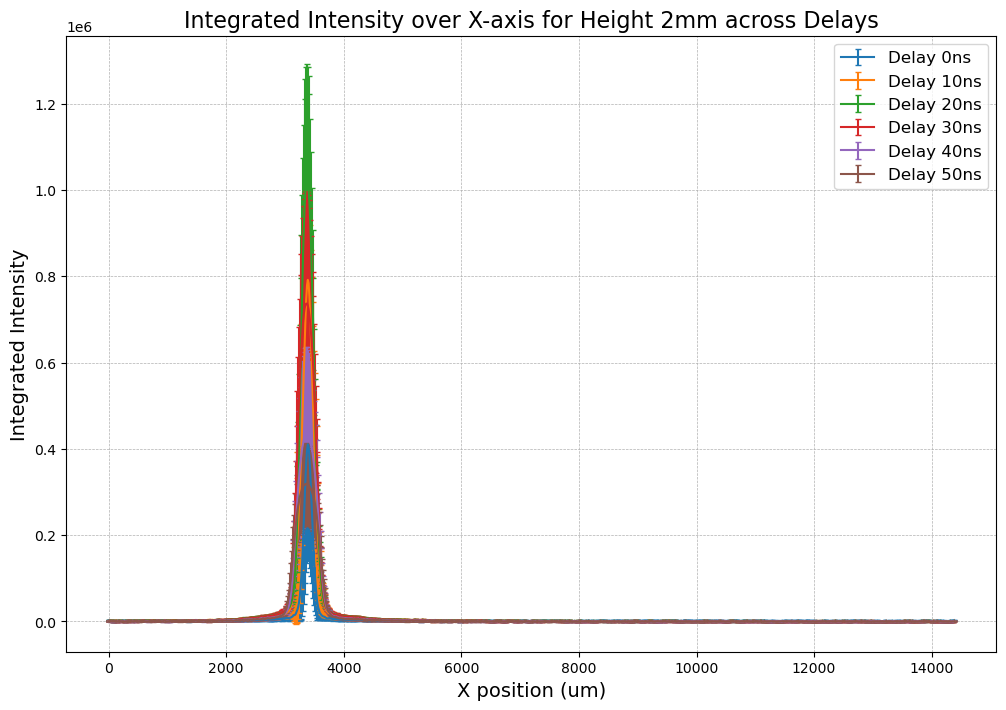

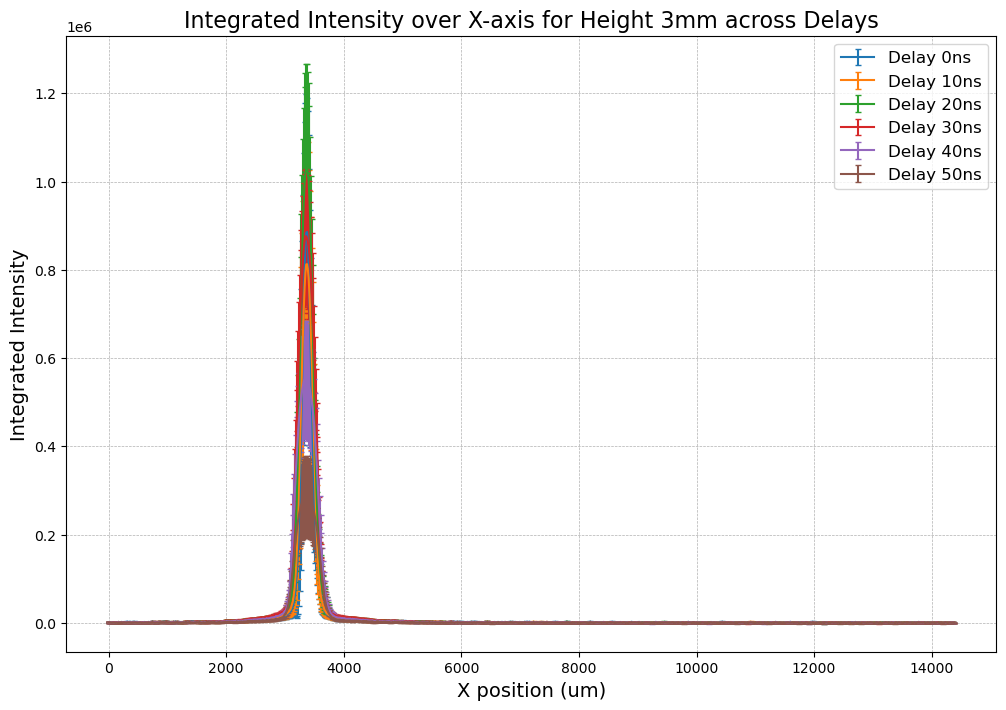

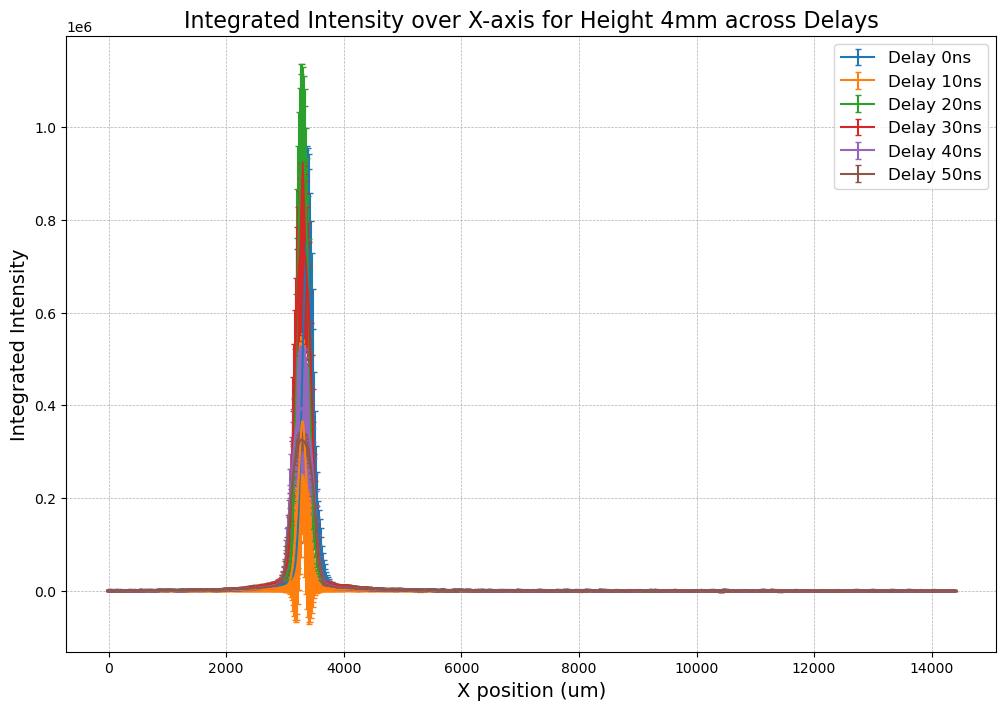

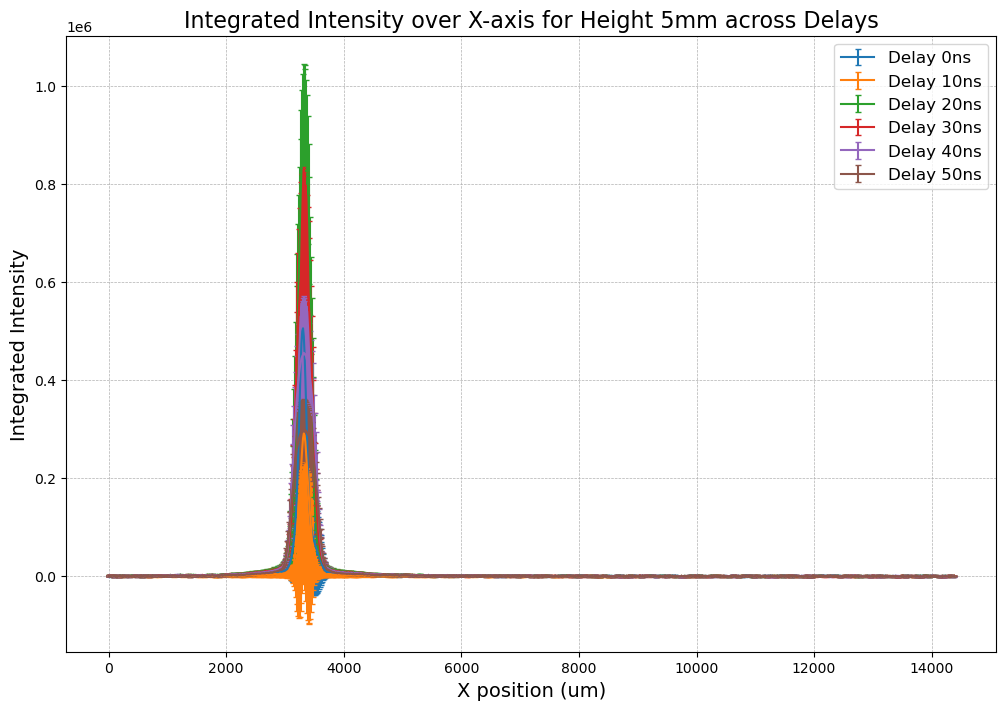

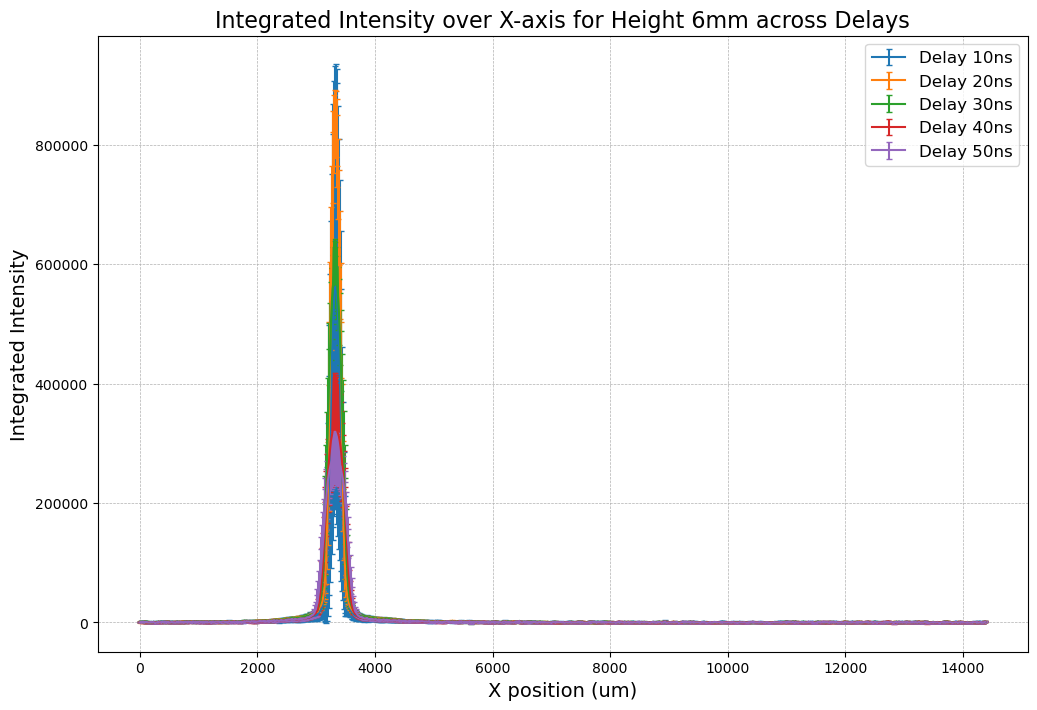

In [34]:

def spatial3(directory, height, output_dir):
    # Dictionary to store data for each delay time
    data_dict = {}
    valid_delays = {0, 10, 20, 30, 40, 50}  # Only process these delays

    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.csv'):
            # Extract delay time and trial number from the filename
            delay_time = int(filename.split('_')[0].replace('ns', ''))
            if delay_time not in valid_delays:
                continue  # Skip if delay_time is not in the valid delays

            trial = int(filename.split('_')[1].split('.')[0])
            file_path = os.path.join(directory, filename)
            
            # Load the CSV file into a DataFrame
            df = load_csv(file_path)
            
            # Separate coordinates and intensity data
            x_coords = df.columns.astype(float)
            intensity_data = df.values
            
            # Sum along the x direction
            spatial_profile = np.sum(intensity_data, axis=0)
            
            # Store the spatial profile in the dictionary
            if delay_time not in data_dict:
                data_dict[delay_time] = []
            data_dict[delay_time].append(spatial_profile)
    
    # Process each delay time to calculate the average and standard deviation
    plt.figure(figsize=(12, 8))
    for delay_time, profiles in data_dict.items():
        profiles = np.array(profiles)
        avg_profile = np.mean(profiles, axis=0)
        std_profile = np.std(profiles, axis=0)
        
        plt.errorbar(x_coords, avg_profile, 
                     yerr = std_profile,
                     fmt='-', capsize=2, label=f'Delay {delay_time}ns')
    
    plt.xlabel('X position (um)', fontsize=14)
    plt.ylabel('Integrated Intensity', fontsize=14)
    plt.title(f'Integrated Intensity over X-axis for Height {height}mm across Delays', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    


def spatial_all3(base_directory, media, output_dir):
    heights = range(0, 7, 1)  # Adjust the height range as needed
    
    for height in heights:
        data_directory = os.path.join(base_directory, f'{height}mm', 'CSV')
        
        if os.path.exists(data_directory):
            print(f'Processing {media} at {height}mm...')
            # Process the data files
            spatial3(data_directory, height, output_dir)
        else:
            print(f'Directory {data_directory} does not exist, skipping.')


spatial_all3(base_directory, 'media', output_dir)